In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

### Dataset Used
The **processed.cleveland.data** dataset from the UCI Machine Learning Repository is part of a collection of datasets related to heart disease. This specific dataset contains 14 features used to predict the presence of heart disease in patients. Here's a brief description of each feature:

Changing the column numbers to column names using information providedbelow:


1. **age**: Age of the patient in years.
2. **sex**: Gender of the patient (1 = male, 0 = female).
3. **cp**: Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic).
4. **trestbps**: Resting blood pressure (in mm Hg on admission to the hospital).
5. **chol**: Serum cholesterol level in mg/dl.
6. **fbs**: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false).
7. **restecg**: Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy).
8. **thalach**: Maximum heart rate achieved.
9. **exang**: Exercise-induced angina (1 = yes, 0 = no).
10. **oldpeak**: ST depression induced by exercise relative to rest.
11. **slope**: Slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping).
12. **ca**: Number of major vessels (0-3) colored by fluoroscopy.
13. **thal**: Thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect).
14. **hd**: Diagnosis of heart disease (0 = less than 50% diameter narrowing, 1 = greater than 50% diameter narrowing, i.e., heart disease presence).

The `hd` variable is the outcome, where the goal is to predict whether a patient has heart disease.

In [71]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                header=None)

print("shape of the df is: ", df.shape)

shape of the df is:  (303, 14)


In [72]:
df.columns=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca','thal', 'hd']

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [73]:
# Checking for missing data
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
hd          0
dtype: int64

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  hd        303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


Botj `ca` and `thal` are of object type but they should be float as per data information, lets check their unique values.

In [75]:
df.ca.unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [76]:
df.thal.unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Both of these features have some `?` fields that means data is missing in these rows. We can deal with missing values in the data by either dropping these rows where data is missing or we can can impute data in these rows.

In [77]:
df.ca.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [78]:
df.thal.value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

We can see in total there are six rows where data is missing in our dataset. Since the number is not that large, we can drop these rows from our dataset as these do not result in significant data loss.

In [79]:
df = df.loc[~((df['ca']=='?')|(df['thal']=='?'))]
print("Shape of dataframe after dropping the rows: ", df.shape)

Shape of dataframe after dropping the rows:  (297, 14)


### Converting categorical features into one hot encoded vectors:
Features `cp`, `restecg`, `slope`, `thal` are categorical in nature and have multiple categories, so we need to one-hot encode them. On the other hand features like `sex`, `fbs`, `exang` are also categorical but have only two categories so we can treat them as one-hot encoded directly.

In [80]:
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,hd,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,0,0,0,0,1,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,2,0,0,1,0,1,1,0,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,0,0,1,0,1,1,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,0,1,0,0,0,0,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,0.0,1,0,0,1,0,0,1,0,0,1
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,0.0,1,0,0,0,0,0,1,0,0,1
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,2.0,2,0,0,1,0,0,1,0,0,1
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,3,0,0,1,0,0,1,0,0,1


In this problem, we only want to classify people whether they will have a heart disease or not, but in the given dataset it also predicts the severity of the heart disease into different levels. For our purpose we can convert all the `hd` values >=1 as 1 meaning having heart disease.

In [81]:
df['hd'].unique()

array([0, 2, 1, 3, 4])

In [82]:
df.loc[df['hd'] >= 1, 'hd'] = 1
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,hd,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,0,0,0,0,1,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1,0,0,1,0,1,1,0,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,0,0,1,0,1,1,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,0,1,0,0,0,0,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,0.0,1,0,0,1,0,0,1,0,0,1
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,0.0,1,0,0,0,0,0,1,0,0,1
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,2.0,1,0,0,1,0,0,1,0,0,1
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,1,0,0,1,0,0,1,0,0,1


In [83]:
df['hd'].unique()

array([0, 1])

In [84]:
## Splitting the dataset into independent and dependent set
X = df.drop(columns='hd', axis=1)
Y = df['hd']

print(X.shape, Y.shape)

(297, 18) (297,)


### Splitting the data into train and test set

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### Creating a decision tree using Sklearn library

In [88]:
dt = DecisionTreeClassifier(random_state=42)

In [89]:
clf_dt = dt.fit(X_train, Y_train)
Y_predict = clf_dt.predict(X_test)

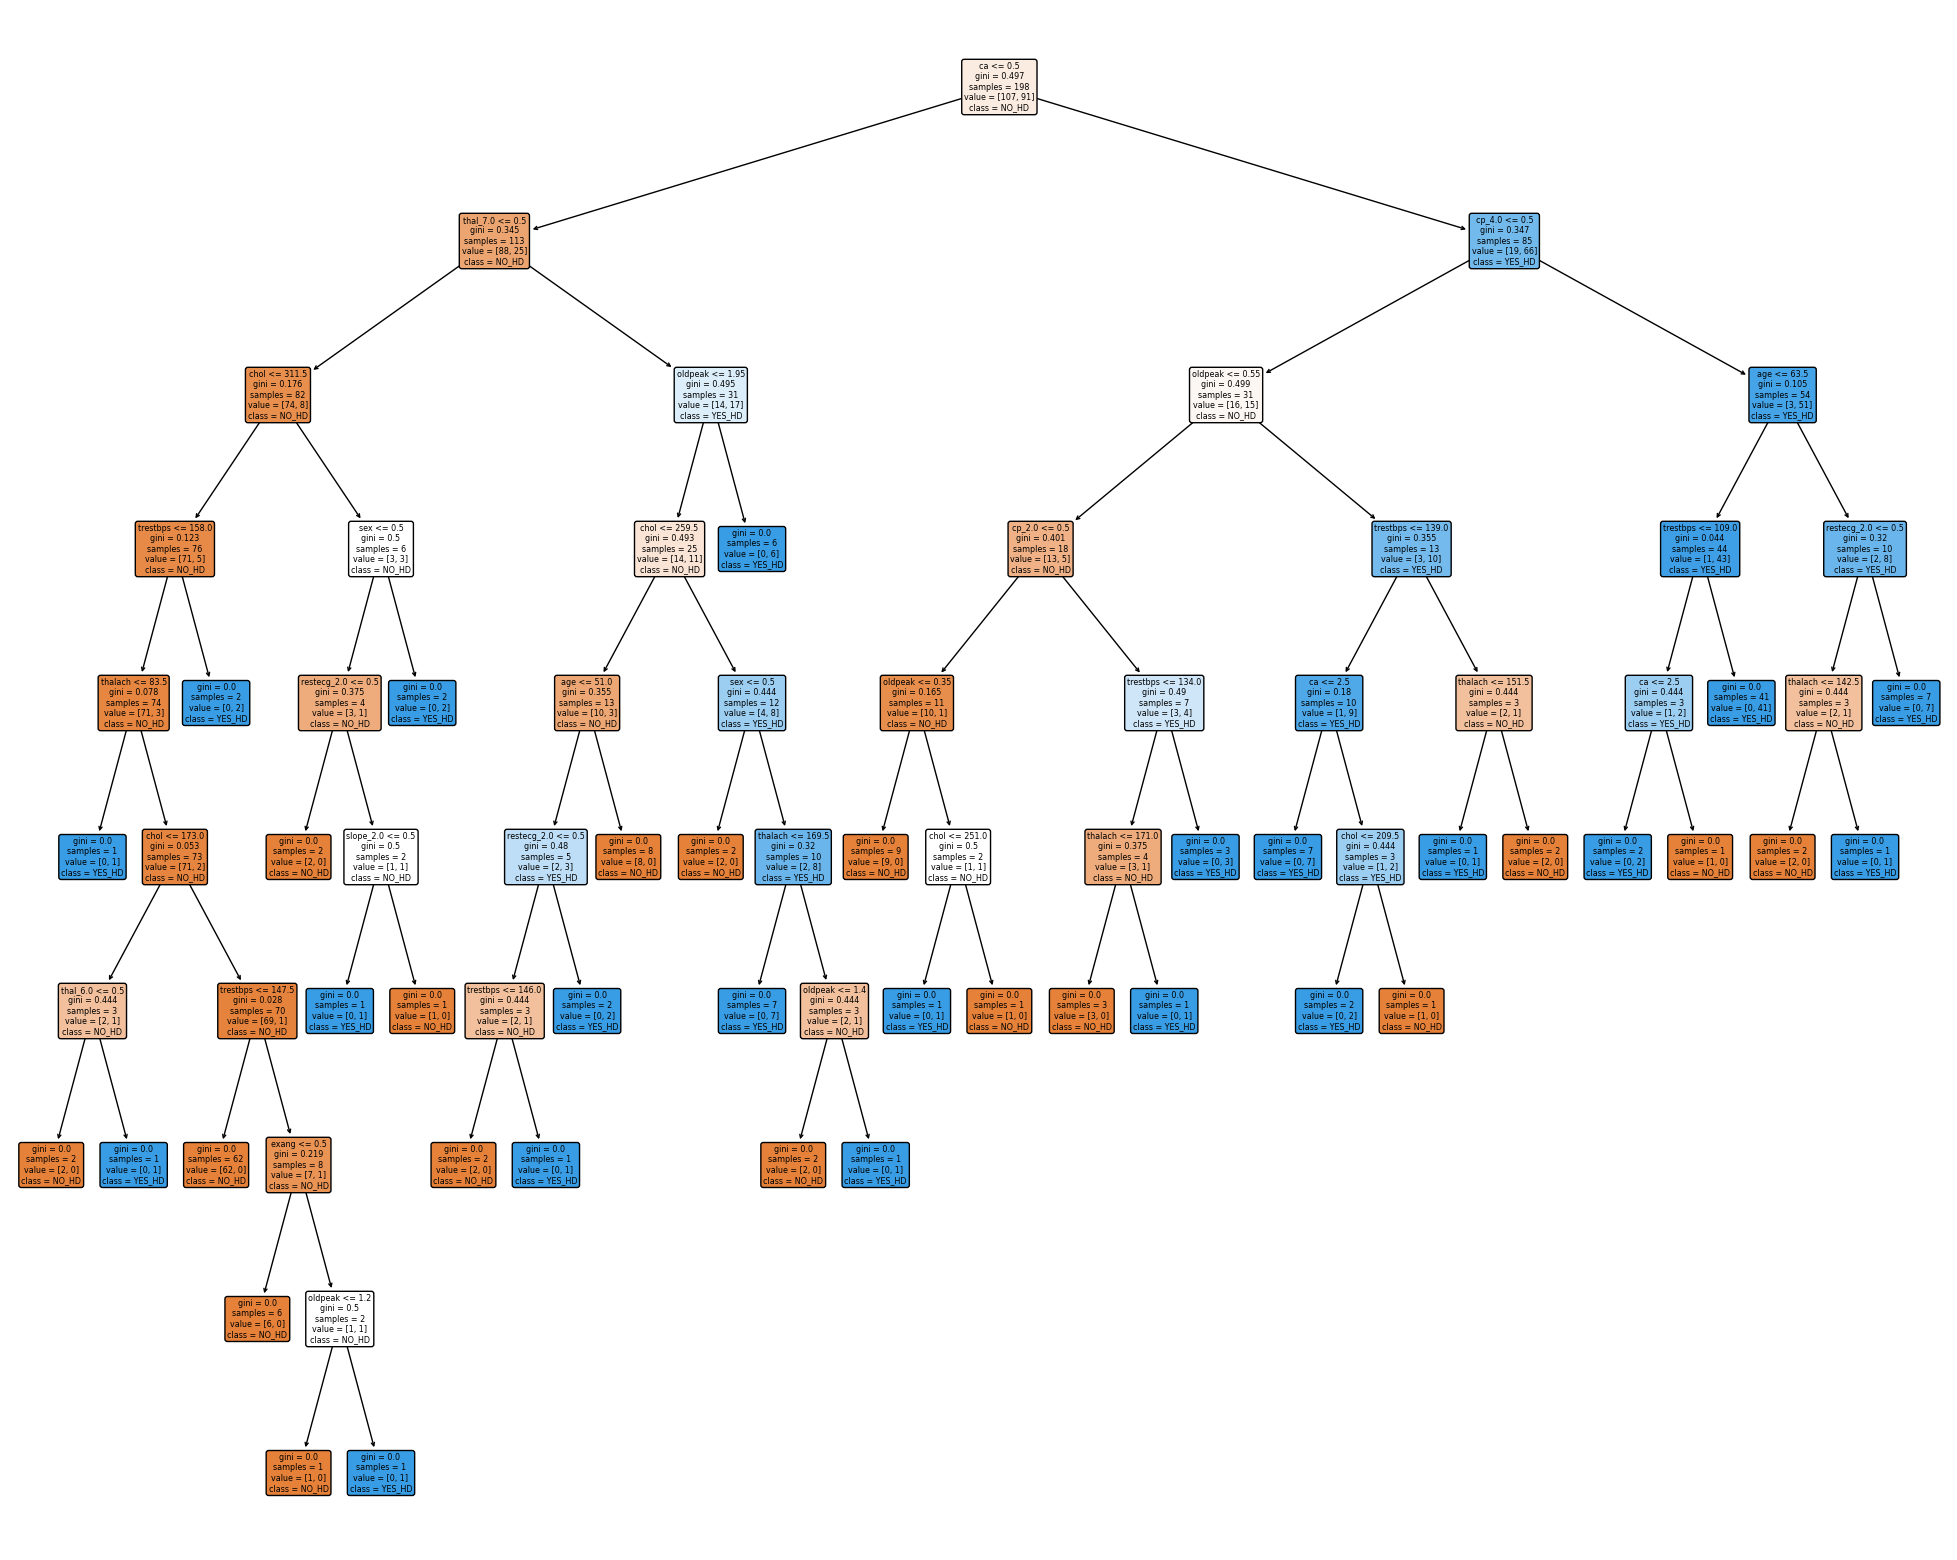

In [90]:
# Plotting our decision tree
plt.figure(figsize=(25,20))
plot_tree(clf_dt, filled=True, rounded=True,
          class_names=['NO_HD', 'YES_HD'],
         feature_names=X_train.columns);
plt.show()

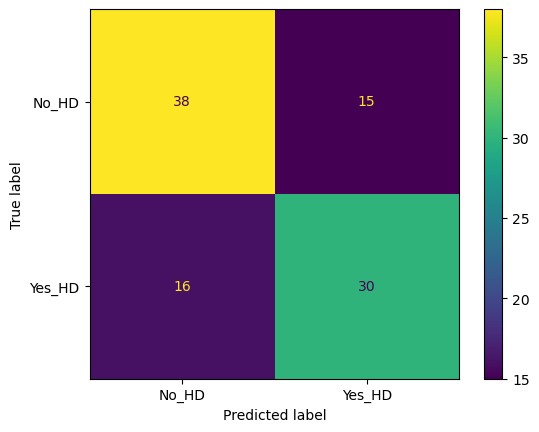

In [91]:
# Plotting our confusion matrix on test data
ConfusionMatrixDisplay.from_estimator(clf_dt, X_test, Y_test,
                                     display_labels=['No_HD', 'Yes_HD'])

Preventing overfitting in our decision tree by doing post pruning using the method of **Cost complexity pruning CCP**

In [92]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train) # determines values of alpha
ccp_alphas = path.ccp_alphas # extracts different values of alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

clf_dts = [] # a list for storing different decision trees

# Creating one decision tree per ccp_alpha value and store it in the list
for i in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=i)
    clf_dt.fit(X_train, Y_train)
    clf_dts.append(clf_dt)

Now let's graph the accuracy of these decision trees using Training dataset and testing dataset as a function of alpha.

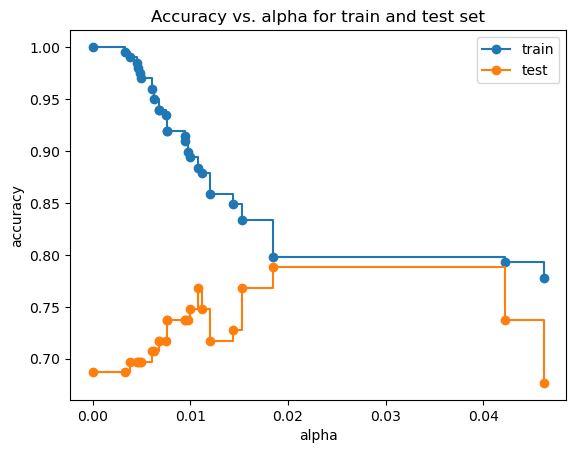

In [93]:
train_scores = [tree.score(X_train, Y_train) for tree in clf_dts]
test_scores = [tree.score(X_test, Y_test) for tree in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs. alpha for train and test set')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

In the graph shown above, we see that the accuracy for test dataset hits its maximum when the alpha is about **0.016**. After this value of alpha, the accuracy of the train dataset drops off and that suggests we should set `ccp_alpha = 0.016`.

**Note:** When we apply cost-complexity pruning to a **Classification Tree**, value for alpha goes from **0 to 1**. The values of alpha for a **Regression Tree** can be much larger since the sum of squarred residuals can range for 0 to positive infinity.

### Using K-fold cross-validation for finding the best alpha

First lets demonstrate that different train and test sets results in trees with different accuracies, when we set `ccp_alpha=0.016`. We will use the **cross_val_score** function to generate different training and testing datasets and then train and test the tree with those datasets.

<Axes: xlabel='tree'>

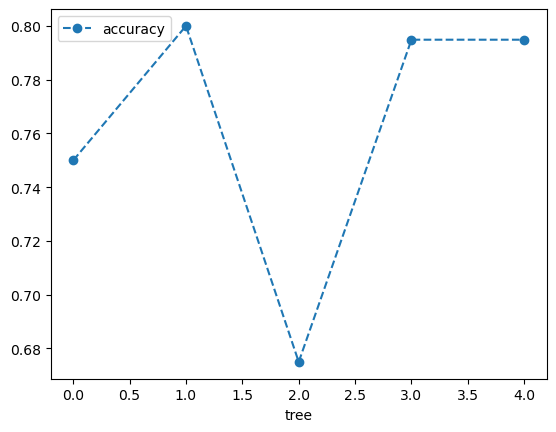

In [94]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.019)

# Using a 5-fold cross validation to create 5 different training and testing datasets
# that are then used to train and test the tree.
scores = cross_val_score(clf_dt, X_train, Y_train, cv=5)
res_df = pd.DataFrame(data={'tree':range(5), 'accuracy':scores})

res_df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

The graph shows that using different training and testing data with the same alpha resulted in different accuracies, suggesting that `aplha` is sensitive to the datasets. So instead of picking a single training dataset and single testing dataset, we should use cross_validation for finding the optimal value for `ccp_alpha`.

<Axes: xlabel='alpha'>

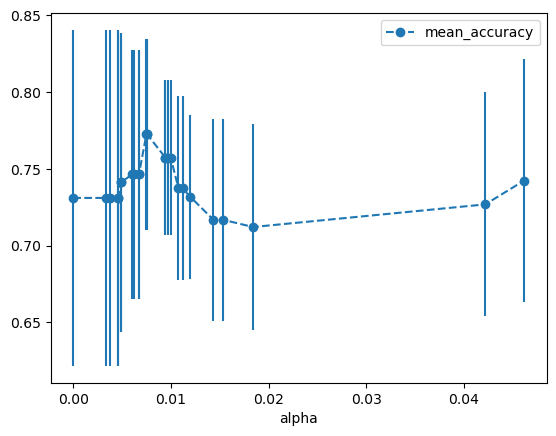

In [95]:
#A list to store the results of each fold during cross-validation
alpha_values = []

# For each candidate value of alpha, we will run 5-fold cross-validation
# then we will store mean and standard deviations of the score (the accuracy) for each call
# to cross_val_score in alpha_values...

for i in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=i)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv=10)
    alpha_values.append([i, np.mean(scores), np.std(scores)])
    
# Now we can draw a graph of the mean and standard deviations of the scores
# for each candidate value of alpha

alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

Using cross-validation, we can observe that, instead of setting `ccp_alpha=0.016`, we neeed to set it to something closer to `0.011`. We can find the exact value of alpha with:

In [102]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha']>0.007)
                               &
                               (alpha_results['alpha']<0.008)]['alpha']
ideal_ccp_alpha = float(ideal_ccp_alpha.max())
ideal_ccp_alpha

0.007575757575757576

Now, we can use this `ccp_alpha` value to build our decision tree.

In [103]:
final_pruned_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ideal_ccp_alpha)
final_pruned_dt = final_pruned_dt.fit(X_train, Y_train)

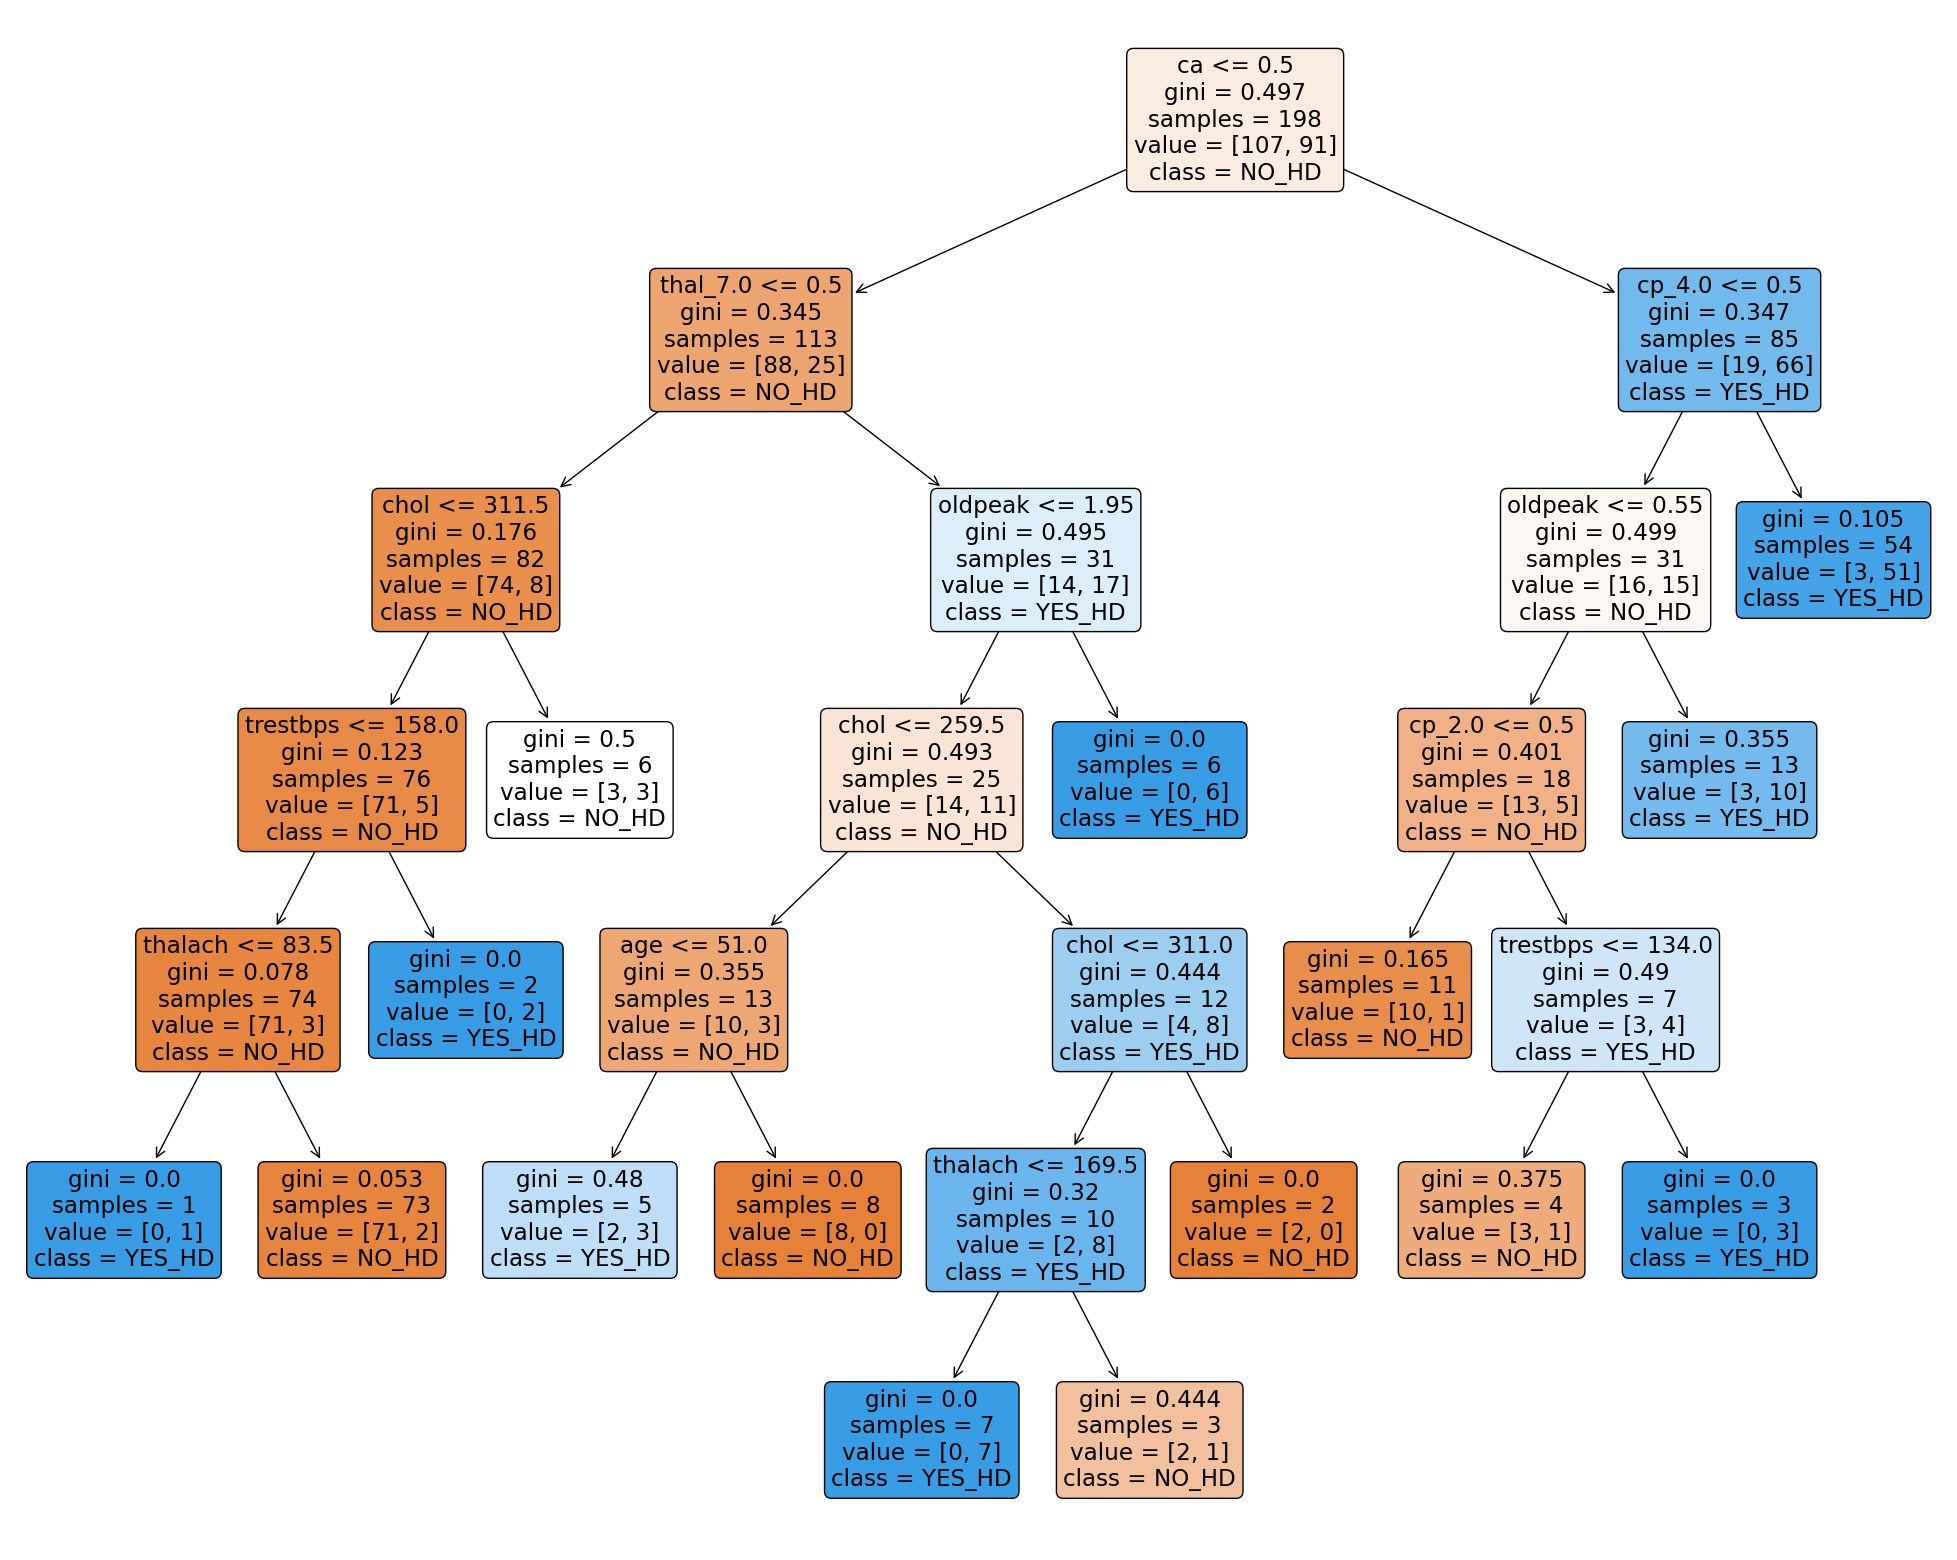

In [104]:
# Plotting our pruned decision tree
plt.figure(figsize=(25,20))
plot_tree(final_pruned_dt, filled=True, rounded=True,
          class_names=['NO_HD', 'YES_HD'],
         feature_names=X_train.columns);
plt.show()

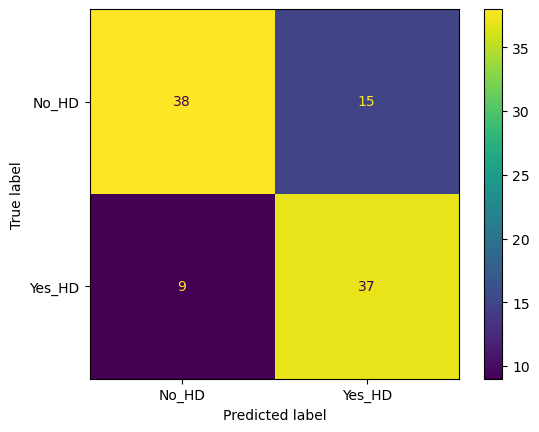

In [105]:
# Plotting our confusion matrix on test data
ConfusionMatrixDisplay.from_estimator(final_pruned_dt, X_test, Y_test,
                                     display_labels=['No_HD', 'Yes_HD'])